In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import argparse
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import math
from os import listdir
from os.path import join

In [2]:
from torchvision import transforms
import pickle
import nltk
from pycocotools.coco import COCO
#! pip install pycocotools

In [3]:
crop_size=250
#vocab_path='./Dataset_coco/vocab.pkl'
vocab_path = './vocab.pkl'
MAX_LENGTH = 57

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reading & Resizing Coco Dataset

In [5]:
# TRAIN_PATH = Path("./Dataset_coco/train2014")
# TRAIN_OUTPATH = Path("./Dataset_coco/n_train2014")

# VAL_PATH = Path("./Dataset_coco/val2014")
# CAPTION_PATH = './Dataset_coco/annotations/captions_train2014.json'

TRAIN_PATH = Path("./train2014/train2014")
TRAIN_OUTPATH = Path("./Dataset_coco/n_train2014_2")
#TRAIN_OUTPATH2 = Path("./Dataset_coco/n_train2014_2")

VAL_PATH = Path("./val2014/val2014")
VAL_OUTPATH = Path("./Dataset_coco/n_valid2014")

CAPTION_TRAIN_PATH = './annotations/annotations/captions_train2014.json'
CAPTION_VAL_PATH = './annotations/annotations/captions_val2014.json'

In [ ]:
! ls ./train2014/train2014 | wc -l

In [6]:
def read_image(path):
    im = mpimg.imread(path) 
    return im

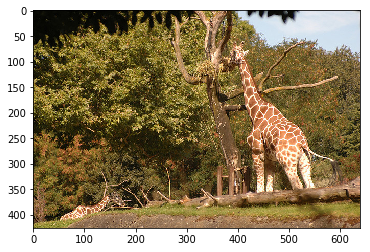

In [7]:
path = TRAIN_PATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im.shape  # R,G,B

(426, 640, 3)

In [9]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(im, (sz, sz))
#     return cv2.resize(center_crop_square(im), (sz, sz))

def resize_all_images(input_path, output_path):
    
    input_path_str = str(input_path)
    for i,f in enumerate(os.listdir(input_path_str)):
       
        if f=='.DS_Store': continue
        
        img = get_a_crop(input_path_str+"/"+f)
        out_path_str = str(output_path) + "/"+f

        cv2.imwrite(out_path_str, img)
        
        if i%10000==0:
            print(f"Processed {i} images")
            print(out_path_str)


In [ ]:
#resize_all_images(TRAIN_PATH, TRAIN_OUTPATH)

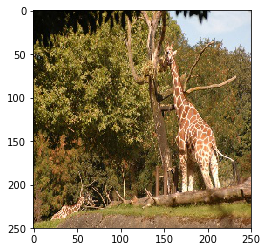

In [11]:
# Testing
path = TRAIN_OUTPATH/"COCO_train2014_000000000025.jpg"
im = read_image(path)
plt.imshow(im)

In [12]:
im.shape

(250, 250, 3)

## Creating Dataloaders

In [13]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [14]:
transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

transform2 = transforms.Compose([ 
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [15]:
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [169]:
class CocoDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None, N=MAX_LENGTH, padding_start=True):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
        self.N = N + 2
        self.padding_start = padding_start

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        enc = np.zeros(self.N, dtype=np.int32)
        enc1 = np.array(caption)
        l = min(self.N, len(enc1))
        if self.padding_start:
            enc[:l] = enc1[:l]
        else:
            enc[self.N-l:] = enc1[:l]        

        target = torch.Tensor(enc)
        return image, target

    def __len__(self):
        return len(self.ids)

In [170]:
train_ds = CocoDataset(TRAIN_OUTPATH,CAPTION_TRAIN_PATH,vocab,transform, N=MAX_LENGTH, padding_start=True )

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [59]:
#valid_ds = CocoDataset(VALID_OUTPATH,CAPTION_VAL_PATH,vocab,transform2, N=MAX_LENGTH, padding_start=True )
valid_ds = CocoDataset(TRAIN_OUTPATH,CAPTION_TRAIN_PATH,vocab,transform, N=MAX_LENGTH, padding_start=True )

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [ ]:
# max_len=0
# for i in range(n):
#     lenTensor=len(train_ds[i][1])
#     if lenTensor>max_len:
#         max_len=lenTensor
#     if i%10000==0:
#         print(i)
    

In [172]:
batch_size=10
train_dl = DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True)
#valid_dl = DataLoader(dataset=valid_ds,batch_size=batch_size,num_workers=4)

In [123]:
valid_dl = DataLoader(dataset=valid_ds,batch_size=batch_size)

In [173]:
len(train_ds)

414113

In [159]:
img, caption = next(iter(train_dl))

In [114]:
img.shape, caption.shape

(torch.Size([100, 3, 250, 250]), torch.Size([100, 59]))

In [ ]:
img

In [61]:
img, caption = next(iter(valid_dl))

In [62]:
img.shape, caption.shape

(torch.Size([100, 3, 250, 250]), torch.Size([100, 59]))

### BLEU Evaluation

Reference for BLEU-evaluation from NLTK (https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)

In [22]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

In [23]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is', 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
print(score)


1.0


In [24]:
from nltk.translate.bleu_score import corpus_bleu
references = [ [['this', 'is', 'a', 'quiz'], ['this', 'is', 'test']]] #or hypothesis
candidates = [['this', 'is', 'a', 'test']]
print("BLEU-1 score", corpus_bleu(references, candidates,weights=(1, 0, 0, 0)))
print("BLEU-2 score", corpus_bleu(references, candidates,weights=(0, 1, 0, 0)))
print("BLEU-3 score", corpus_bleu(references, candidates,weights=(0, 0, 1, 0)))
print("BLEU-4 score", corpus_bleu(references, candidates,weights=(0, 0, 0, 1)))

BLEU-1 score 1.0
BLEU-2 score 0.6666666666666666
BLEU-3 score 0.5
BLEU-4 score 2.2250738585072626e-308


/home/default_user/.conda/envs/user/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## Model 

In [36]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        #self.linear = nn.Linear(resnet.fc.in_features, embed_size) #Normal resnet
        self.linear = nn.Linear(resnet.fc.in_features*4, embed_size) #Airbnb resnet
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        
#        print("shape features after resnet", features.shape)
        features = features.reshape(features.size(0), -1)

        features = self.bn(self.linear(features))
        return features
    
#shape torch.Size([100, 3, 250, 250])
# img shape torch.Size([100, 3, 250, 250])
# shape features after resnet torch.Size([100, 2048, 2, 2])
# shape fe torch.Size([100, 8192])

class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=0)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded, hidden)
        output = self.out(hidden[-1])
        return output, hidden    

In [42]:
def train_batch(x, y, encoder, decoder, encoder_optimizer, decoder_optimizer,
                teacher_forcing_ratio=0.5):

    encoder.train()
    decoder.train()    
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size = y.size(0)
    target_length = y.size(1)
    
    enc_hidden = encoder(x) 
    enc_hidden = enc_hidden.unsqueeze(0) # adding one dimension 
    
    loss = 0
    dec_input = y[:,0].unsqueeze(1) # allways SOS
    hidden = enc_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(1, target_length):
        output, hidden = decoder(dec_input, hidden)
        yi =  y[:, di]
        if (yi>0).sum() > 0:
            # ignoring padding
            #print("outputs",output,yi)
            loss += F.cross_entropy(output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        if use_teacher_forcing:
            dec_input = y[:, di].unsqueeze(1)  # Teacher forcing: Feed the target as the next input
        else:                
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [27]:
def valid_batch(x, y, encoder, decoder, max_length=MAX_LENGTH+2):
    
    decoder = decoder.eval()
    encoder = encoder.eval()
    loss = 0
    bleu4 = 0
    with torch.no_grad():  
        
        batch_size = x.size(0)
        
        hidden = encoder(x) 
        hidden = hidden.unsqueeze(0) # adding one dimension 

        dec_input = SOS_token*torch.ones(batch_size, 1).long() #.cuda()  # SOS
        decoded_words = []
        for di in range(1, max_length):
            output, hidden = decoder(dec_input, hidden)
            pred = output.argmax(dim=1)
            #predicted tokens (not sentence)
            decoded_words.append(pred.numpy()) #(pred.cpu().numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()
            yi =  y[:, di]

            if (yi>0).sum() > 0:
                # ignoring padding
                loss += F.cross_entropy(
                    output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        
        
        return loss.item(), np.transpose(decoded_words)

In [28]:
def computing_BLEU(decoded_words , target):
    """
    # Decision based on BLEU-n
        # To-do
        # reference: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning/blob/master/train.py
        
    """
    bleu_score = 0
    
    
    return bleu_score

In [29]:
def save_model(m, p): torch.save(m.state_dict(), p)

def load_model(m, p): m.load_state_dict(torch.load(p))

In [193]:
def train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10,
          teacher_forcing_ratio=0.5):
    
    best_bleu4 = 0 
    predicted_captions_val = []
    best_loss = 10000000000
    for i in range(epochs):
        
        print(f'epoch {i}')
        total_loss = 0
        total_loss_valid = 0
        loss_valid = 0
        total = 0
        total_valid = 0
#         encoder.train()
#         decoder.train()
        
        # One epoch training 
        for x, y in train_dl:
            #print("batch loaded")
            x = x.float().cuda()
            y = y.long().cuda()
            
            #print("initiating training")
            loss = train_batch(x, y, encoder, decoder, enc_optimizer, dec_optimizer,
                               teacher_forcing_ratio)
            #print('finished training')
            total_loss = loss*x.size(0)
            total += x.size(0)
            
#         # One epoch validation
#         list_decoded_words = []
#         for x, y in valid_dl:  
#             x = x.float().cuda()
#             y = y.long().cuda()
            
#             loss_valid, decoded_words  = valid_batch(x, y, encoder, decoder)
#             total_loss_valid += loss_valid*x.size(0)
#             total_valid += x.size(0)
#             list_decoded_words.append(decoded_words) 

        if (total_loss / total)<best_loss:
            best_loss = total_loss / total
            best_path_enc = "./model/model_enc_{0:.4f}.pth".format(best_loss)
            best_path_dec = "./model/model_dec_{0:.4f}.pth".format(best_loss)
            save_model(encoder, best_path_enc)               
            save_model(decoder, best_path_dec)                           
            
# val_loss, val_r2 = val_metrics(model, valid_dl)
#         print("\tTrain loss: {:.3f} \t Valid loss: {:.3f} \t Valid R2:  {:.3f}".format(
#             total_loss/total, val_loss, val_r2))  
#         if best_val_r2 < val_r2:
#             best_val_r2 = val_r2
#             best_path = "{0}/models/model_{1}_acc_{2:.0f}.pth".format(PATH, dataset, 100*val_r2)
#             save_model(model, best_path)            
            
#         bleu4 = 0 #computing_BLEU(decoded_words, y)
        
#         if bleu4 >= best_bleu4:
#             best_bleu4 = bleu4
#             predicted_captions_val = list_decoded_words
#             #save pytorch model 

        #if i%10 == 0:
    
#         print("train loss %.3f valid loss %.3f bleu-4 %.3f" % (total_loss / total, 
#                                                                total_loss_valid / total_valid,
#                                                                best_bleu4
#                                                               )) 

        print("train loss %.3f" % (total_loss / total ))  
    
    return best_path_enc, best_path_dec #best_bleu4, predicted_captions_val 

In [194]:
output_size = len(vocab)
hidden_size = 300  #embedding size of the img

encoder = EncoderCNN(hidden_size).cuda()
decoder = DecoderRNN(output_size, hidden_size).cuda()
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.001) 

In [195]:
batch_size=500
train_dl = DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True)
#valid_dl = DataLoader(dataset=valid_ds,batch_size=batch_size,num_workers=4)

In [184]:
len(train_ds)

414113

In [ ]:
#best_bleu4, predicted_captions_val = train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 2)
best_path_enc, best_path_dec = train(encoder, decoder, enc_optimizer, dec_optimizer, epochs = 10)

epoch 0


In [128]:
best_path_enc

'./model/model_enc_6.4132.pth'

In [129]:
load_model(decoder, "./model/model_dec_0.1080.pth")
load_model(encoder, "./model/model_enc_0.1080.pth")

## Evaluating the model (drafts only, we will delete it later)

In [134]:
def decoding(x, y, encoder, decoder, max_length=MAX_LENGTH+2):
    decoder = decoder.eval()
    encoder = encoder.eval()
    loss = 0
    with torch.no_grad():   
        batch_size = x.size(0)
        
        #enc_outputs, hidden = encoder(x)
        hidden = encoder(x) 
        hidden = hidden.unsqueeze(0) # adding one dimension 
        #print(hidden)
        dec_input = SOS_token*torch.ones(batch_size, 1).long().cuda()  # SOS
        decoded_words = []
        
        for di in range(1, max_length):
            output, hidden = decoder(dec_input, hidden)
            #print(output)
            pred = output.argmax(dim=1)
            #print(pred)
            decoded_words.append(pred.cpu().numpy())
            dec_input = output.argmax(dim=1).unsqueeze(1).detach()
            yi =  y[:, di]
            
            if (yi>0).sum() > 0:
                # ignoring padding
                loss += F.cross_entropy(
                    output, yi, ignore_index = 0, reduction="sum")/(yi>0).sum()
        return loss.item()/batch_size, np.transpose(decoded_words)

In [151]:
#MAX_LENGTH #without SOS and END tokens
SOS_token = 1
EOS_token = 2

batch_size=10
#valid_dl= DataLoader(valid_ds, batch_size=batch_size)
valid_dl= DataLoader(train_ds, batch_size=batch_size)

x, y = next(iter(valid_dl)) 
x = x.float().cuda()
y = y.long().cuda()

loss, decoded_words = decoding(x, y, encoder, decoder)
loss

7.280173492431641

In [152]:
#predicted captions
decoded_words.shape

(10, 58)

In [153]:
xi = decoded_words[9]
print(' '.join([vocab.idx2word[t] for t in xi if t>3]))

a bathroom with a toilet and a a a a a a a . . . . . . . .


In [154]:
xi = y[9].cpu().numpy()
print(' '.join([vocab.idx2word[t] for t in xi if t>3]))

a sink and a toilet inside a small bathroom .


In [ ]:
xi.shape

In [ ]:
#COCO(CAPTION_PATH).anns.keys()
#48, 67, 126, 148, 173,
COCO(CAPTION_PATH).anns[173]